# Object Detection

CNN: Convolutional Neural Network


1. scegliere e caricare il modello pre-trainato: parte 1
2. detection su di una immagine

Detr: Transformers per Object Detection

1. caricare le annotazioni COCO
2. costruire il dataset e il dataloader
2. costruire la funzione di training


In [ ]:
!pip install albumentations==0.4.6
!pip install effdet==0.3.0
!pip install timm==0.4.12

In [17]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
from effdet import EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet

def get_test_efficientdet(model_path: str, device: str):
    """
    creates test model
    input: model_path: where is the model trained from which we take weights
           device: load model using GPU?
    """
    if device=='cpu':
      saved_model=torch.load(model_path, map_location=torch.device('cpu'))
    else:
      saved_model=torch.load(model_path)

    state_dict = saved_model.state_dict()
    net = EfficientDet(saved_model.config, pretrained_backbone=False)
    net.class_net = HeadNet(saved_model.config, num_outputs=saved_model.config.num_classes)
    net = DetBenchPredict(net)
    net.load_state_dict(state_dict)
    net=net.to(device)

    return net

In [19]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import numpy as np

img = Image.open(
    '/content/drive/MyDrive/Colab Notebooks/cnn-models-data/images/15-05-2022_10-00-00.png'
    )
test_model = get_test_efficientdet('/content/drive/MyDrive/Colab Notebooks/cnn-models-data/effdet_best_model.pth', str(device))

<ipython-input-18-86283769c069>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model=torch.load(model_path)


In [25]:
import copy
import torchvision.transforms.functional as FT
from torchvision.ops import nms
from effdet.soft_nms import soft_nms

def image_crop_left(image, boxes=None, labels=None):
    """
    the original image is too unbalanced with respect to width and hight dimensions,
    hence we crop the image in two parts and then we will rebuild the original image
    inputs: image=the original image as tensor
            boxes=None means we are in test setting
            labels=None means we are in test setting
    """
    if boxes is None and labels is None:  # if in test, no need to check boxes
      image=FT.to_tensor(image)
      original_h = image.size(1)
      original_w = image.size(2)
      left = int(np.ceil(original_w-original_w*3/5))
      image=image[:, :, left:]
      new_image=FT.to_pil_image(image)
      return new_image

    else:
      original_h = image.shape[0]
      original_w = image.shape[1]

      left = int(np.ceil(original_w-original_w*3/5))
      crop = torch.FloatTensor([left, 0, original_w, original_h])  # (4)

      new_image = image[:, left:, :]
      # Find centers of original bounding boxes
      bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)
      # Find bounding boxes whose centers are in the crop
      centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < original_w) * (bb_centers[:, 1] > 0) * (bb_centers[:, 1] < original_h)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index
      # Discard bounding boxes that don't meet this criterion
      new_boxes = boxes[centers_in_crop, :]
      new_labels = labels[centers_in_crop]

      # Calculate bounding boxes' new coordinates in the crop
      new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
      new_boxes[:, :2] -= crop[:2]
      new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
      new_boxes[:, 2:] -= crop[:2]

      return new_image, new_boxes, new_labels


def image_crop_right(image, boxes=None, labels=None):
    """
    the original image is too unbalanced with respect to width and hight dimensions,
    hence we crop the image in two parts and then we will rebuild the original image
    inputs: image= the original image as tensor
            boxes= None means we are in test setting
            labels= None means we are in test setting
    """

    if boxes is None and labels is None:
      image=FT.to_tensor(image)
      original_h = image.size(1)
      original_w = image.size(2)
      right = int(np.ceil(original_w*3/5)) -1
      image=image[:, :, :right]
      new_image=FT.to_pil_image(image)
      return new_image

    else:
      original_h = image.shape[0]
      original_w = image.shape[1]
      right = int(np.ceil(original_w*3/5)) -1
      crop = torch.FloatTensor([0, 0, right, original_h])
      new_image = image[:, :right, :]
      bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.
      centers_in_crop = (bb_centers[:, 0] > 0) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > 0) * (bb_centers[:, 1] < original_h)
      new_boxes = boxes[centers_in_crop, :]
      new_labels = labels[centers_in_crop]
      new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])
      new_boxes[:, :2] -= crop[:2]
      new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])
      new_boxes[:, 2:] -= crop[:2]

      return new_image, new_boxes, new_labels


def get_test_transforms(img_size):
    return albumentations.Compose([
            albumentations.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)


def detect(image, effdet_model, min_score):
  """Detection starting from a PIL Image.
    inputs: image=the original image as PIL image
            effdet_model=efficientDet pre-trained model
            min_score=min score for bounding boxes
  """
  img=copy.deepcopy(image)
  img1=image_crop_right(img)
  img2=image_crop_left(img)

  list_image=[img1, img2]
  image_size=effdet_model.config['image_size']
  test_images=[]
  test_info=[]
  transform=get_test_transforms(image_size[0])

  for image in list_image:
    image = np.array(image)
    image = image / 255.0
    image = image.astype(np.float64)

    sample = {
        'image': image,
        'img_size': image_size,
        'img_scale': 1.0
        }
    sample=transform(**sample)
    test_images.append(sample['image'])
    test_info.append({
        'img_size':sample['img_size'],
        'img_scale':sample['img_scale']
    })

  test_images=torch.stack(test_images).float().to(device)
  output=effdet_model(test_images)
  output = output.to('cpu')

  final_boxes=[]
  final_scores=[]
  final_labels=[]

  #now apply soft_nms/nms and consider only boxes with score>min_score
  for i in range(len(output)):
    detections=output[:,:,:-2][i].detach()
    scores=output[:,:,-2][i].detach()
    labels=output[:,:,-1][i].detach()

    index=soft_nms(detections, scores)[0]
    boxes=detections[index]
    scores=scores[index]
    labels=labels[index]
    index2=scores>min_score
    boxes=boxes[index2]
    scores=scores[index2]
    labels=labels[index2]

    final_boxes.append(boxes)
    final_scores.append(scores)
    final_labels.append(labels)


  return final_boxes, final_scores, final_labels

In [22]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    Input: set_1=set 1, a tensor of dimensions (n1, 4)
           set_2=set 2, a tensor of dimensions (n2, 4)
    Output: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2), here we set to zero every negative entry
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    Input: set_1=set 1, a tensor of dimensions (n1, 4)
           set_2=set 2, a tensor of dimensions (n2, 4)
    Output: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """
    intersection = find_intersection(set_1, set_2)  # (n1, n2)
    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    # Find the union
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    return intersection / union  # (n1, n2)


In [23]:
from PIL import ImageDraw


def rebuild_image(img_original, image_size, final_box, final_score, final_label):
      """
      given the boxes coming from the two crops of the original image,
      retrives the boxes in the original image
      """

      annotated_image = FT.to_pil_image(np.copy(img_original))
      img_original=FT.to_tensor(img_original)
      img1_w = image_size[0]
      img1_h = image_size[1]
      img2_w = image_size[0]
      img2_h = image_size[1]
      crop_size_w=772
      crop_size_h=470
      original_h = img_original.size(1)
      original_w = img_original.size(2)

      lista1 = final_box[0].tolist()  # boxes of the left image
      lista2 = final_box[1].tolist()  # boxes of the right image

      scores1= final_score[0]
      scores2= final_score[1]

      label1= final_label[0].tolist()
      label2 = final_label[1].tolist()

      for b in lista1:
        b[0] = (b[0]/img1_w)*crop_size_w  #xmin
        b[2] =  (b[2]/img1_w)*crop_size_w  #xmax
        b[1] = (b[1]/img1_h)*crop_size_h  #ymin
        b[3] =  (b[3]/img1_h)*crop_size_h  #ymax

      for c in lista2:
        c[0] = (c[0]/img1_w)*crop_size_w + original_w-crop_size_w  #xmin
        c[2] =  (c[2]/img1_w)*crop_size_w + original_w-crop_size_w  #xmax
        c[1] = (c[1]/img1_h)*crop_size_h + original_h-crop_size_h  #ymin
        c[3] =  (c[3]/img1_h)*crop_size_h + original_h-crop_size_h  #ymax


      lista1 = torch.FloatTensor(lista1)
      lista2 = torch.FloatTensor(lista2)
      label1= torch.FloatTensor(label1)
      label2=  torch.FloatTensor(label2)
      overlap = find_jaccard_overlap(lista1,lista2)
      values,indices = overlap.max(dim=0)
      for i, val in enumerate(values):
          if val>0.5 :
            index_1= values.tolist().index(val)
            newbox=  [min(lista1[indices[index_1]][0], lista2[i][0]).item(),
                      min(lista1[indices[index_1]][1], lista2[i][1]).item(),
                      max(lista1[indices[index_1]][2], lista2[i][2]).item(),
                      max(lista1[indices[index_1]][3], lista2[i][3]).item()]

            lista1[indices[index_1]] = torch.FloatTensor(newbox)
            lista2[i] = torch.FloatTensor(newbox)

      #eliminate duplicate boxes
      final_boxes = torch.cat((lista1,lista2))
      final_scores = torch.cat((scores1,scores2))
      final_labels = torch.cat((label1,label2))

      indici=[]
      for i,box in enumerate(final_boxes):
        for j in range(i,len(final_boxes)):
          if (box.tolist() == final_boxes[j].tolist()) and (i!=j):
            indici.append(j)

      final_boxes=final_boxes[[i not in indici for i in range(len(final_boxes))]]
      final_scores=final_scores[[i not in indici for i in range(len(final_scores))]]
      final_labels=final_labels[[i not in indici for i in range(len(final_labels))]]

      draw = ImageDraw.Draw(annotated_image)
      for i,box in enumerate(final_boxes.tolist()):
        draw.rectangle(box, outline='red', width=3)
      return annotated_image,final_boxes, final_scores, final_labels


In [33]:
image=copy.deepcopy(img)

results=detect(image, test_model, 0.8)

In [34]:
annotated_image, final_boxes, final_scores, _ = rebuild_image(image, test_model.config['image_size'], results[0], results[1], results[2] )

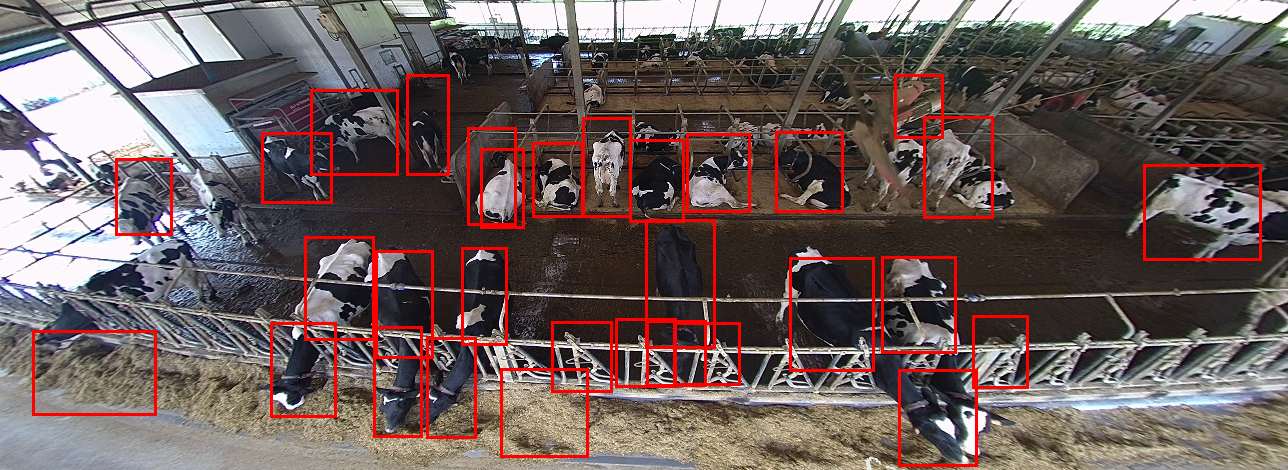

In [35]:
annotated_image

In [36]:
img = Image.open(
    '/content/drive/MyDrive/Colab Notebooks/cnn-models-data/images/20211215-114159.png'
    )
image=copy.deepcopy(img)

results=detect(image, test_model, 0.97)

In [37]:
annotated_image, final_boxes, final_scores, _ = rebuild_image(image, test_model.config['image_size'], results[0], results[1], results[2] )

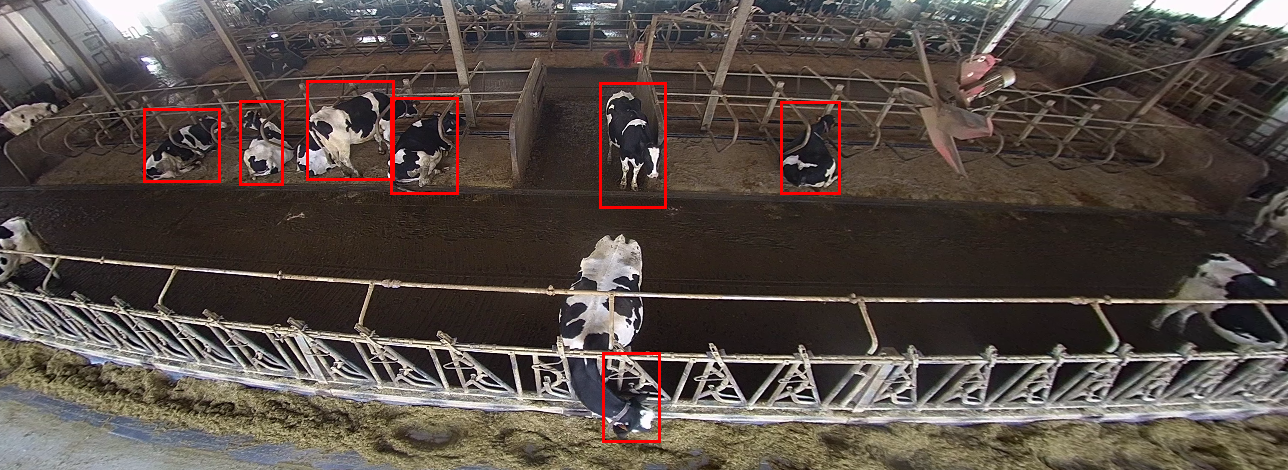

In [38]:
annotated_image

Transformers for Object Detection!

In [ ]:
!pip install transformers

In [2]:
from transformers import DetrForObjectDetection

In [5]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101",
                                               num_labels=1,
                                               ignore_mismatched_sizes=True)

model= model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoi

In [6]:
import torchvision
import os
import matplotlib.pyplot as plt

from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-101")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [7]:
train_dataset = CocoDetection('/content/drive/MyDrive/Colab Notebooks/cnn-models-data/images' ,'/content/drive/MyDrive/Colab Notebooks/cnn-models-data/coco_annotations.json', feature_extractor)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)

In [9]:
import time
from tqdm import tqdm

In [11]:
def train(train_loader,valid_loader, model, optimizer, scheduler, num_epochs):
    """training function:observe the model needs boxes inputs in yxyx format!"""

    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        loop = tqdm(train_loader)
        running_loss = 0.0
        model.train()

        for i, data in enumerate(loop,0):
            pixel_values, pixel_mask, labels= data['pixel_values'], data['pixel_mask'], data['labels']
            pixel_values = pixel_values.to(device)
            pixel_mask = pixel_mask.to(device)
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            optimizer.zero_grad()

            # Forward prop.
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
            loss = outputs.loss
            loss_dict = outputs.loss_dict
            # Backward prop.
            loss.backward()
            #Update:
            optimizer.step()
            running_loss += loss.item()

            if i == len(train_loader)-1:
                    print('loss media sul minibatch training: %.3f' %(running_loss/len(train_loader)))
                    running_loss = 0.0

            loop.set_postfix(loss = loss.item())

        loop_valid = tqdm(valid_loader)
        running_loss_valid = 0.0
        det_boxes_v = list()
        det_labels_v = list()
        det_scores_v = list()
        true_boxes_v = list()
        true_labels_v = list()
        model.eval()
        model_dict={}

        with torch.no_grad():
            for i, data in enumerate(loop_valid,0):
                pixel_values_val ,pixel_mask_val ,labels_val= data['pixel_values'], data['pixel_mask'], data['labels']
                pixel_values_val=pixel_values_val.to(device)
                pixel_mask_val=pixel_mask_val.to(device)
                labels_val = [{k: v.to(device) for k, v in t.items()} for t in labels_val]

                outputs = model(pixel_values=pixel_values_val, pixel_mask=pixel_mask_val, labels=labels_val)

                valid_loss = outputs.loss
                valid_loss_dict = outputs.loss_dict

                # no backward and optimizer.step/zero_grad in validation
                # Update:
                running_loss_valid += valid_loss.item()

                # Print status
                if i == len(valid_loader)-1:
                            scheduler.step()
                            scheduler.get_last_lr()
                            print('loss media sul minibatch valid: %.6f' %(running_loss_valid/len(valid_loader)))

                            if(running_loss_valid/len(valid_loader))<=best_loss:
                                            best_loss = running_loss_valid/len(valid_loader)
                                            #relative_map = mAP_valid
                                            tempo=time.localtime()
                                            print('Best Model until now, not saving')

                            running_loss_valid = 0.0

            loop_valid.set_postfix(loss = valid_loss.item())


    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))


In [ ]:
for param in model.model.input_projection.parameters():
    param.requires_grad = False
for param in model.model.query_position_embeddings.parameters():
    param.requires_grad = False
for param in model.model.decoder.parameters():
    param.requires_grad = False

In [13]:
lr=0.0001
lr_backbone=0.001
weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay, amsgrad=False)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[35],gamma = 0.1,verbose = True, )

In [15]:
train(train_dataloader, train_dataloader, model, optimizer, scheduler, 10)

Epoch 0/9
----------


100%|██████████| 1/1 [00:02<00:00,  2.12s/it, loss=4.78]


loss media sul minibatch training: 4.780


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


loss media sul minibatch valid: 4.593984
Best Model until now, not saving
Epoch 1/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=4.63]


loss media sul minibatch training: 4.627


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


loss media sul minibatch valid: 3.850841
Best Model until now, not saving
Epoch 2/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, loss=3.82]


loss media sul minibatch training: 3.817


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


loss media sul minibatch valid: 3.207835
Best Model until now, not saving
Epoch 3/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, loss=3.19]


loss media sul minibatch training: 3.185


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


loss media sul minibatch valid: 3.129066
Best Model until now, not saving
Epoch 4/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, loss=3.03]


loss media sul minibatch training: 3.027


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


loss media sul minibatch valid: 3.331493
Epoch 5/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.80it/s, loss=3.41]


loss media sul minibatch training: 3.413


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


loss media sul minibatch valid: 3.127559
Best Model until now, not saving
Epoch 6/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.82it/s, loss=3.08]


loss media sul minibatch training: 3.076


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


loss media sul minibatch valid: 3.779107
Epoch 7/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.79it/s, loss=3.29]


loss media sul minibatch training: 3.290


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


loss media sul minibatch valid: 4.196828
Epoch 8/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, loss=3.75]


loss media sul minibatch training: 3.754


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


loss media sul minibatch valid: 3.501880
Epoch 9/9
----------


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, loss=3.3]


loss media sul minibatch training: 3.297


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

loss media sul minibatch valid: 3.153197
Training complete in 0m 10s
Best val loss: 3.127559
